**2.2.3 version of Matplolib is required**    


In [19]:
import sys
import numpy.random as npr
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,6)
plt.rcParams["font.size"] = 16.0

import numpy as np
from numpy.testing import assert_array_equal

from carl.carl.distributions import Mixture, MultivariateNormal, Uniform, Normal
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata

np.random.seed(1)

# **Generating samples X,Y,S**

In [20]:
p0 = MultivariateNormal(mu=np.array([0., 0.]), sigma=np.array([[1., -0.5], [-0.5, 1.]]))
p1 = MultivariateNormal(mu=np.array([1., 1.]), sigma=np.eye(2))
ps = Normal(mu=0.0, sigma=1.0)

n_samples = 125000

X0 = p0.rvs(n_samples // 2, random_state = 1)
X1 = p1.rvs(n_samples // 2, random_state = 1)
s = ps.rvs(n_samples, random_state = 1).ravel()
X1[:, 1] += 3*np.sin(s[n_samples // 2:])

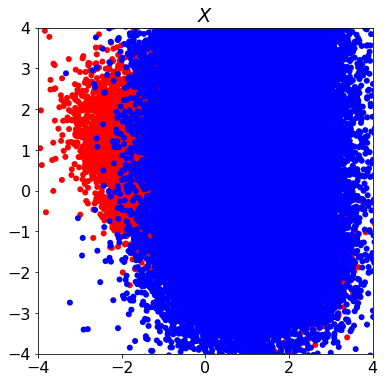

In [21]:
X = np.vstack([X0, X1])
y = np.zeros(n_samples)
y[n_samples // 2:] = 1


plt.title("$X$")
plt.scatter(X[y==0, 0], X[y==0, 1], c="r", marker="o", edgecolors="none")
plt.scatter(X[y==1, 0], X[y==1, 1], c="b", marker="o", edgecolors="none")
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, sensitive, sensitivet = train_test_split(X, y, s, test_size=50000, random_state = 1)


# **Model training**

In [23]:
H = 8
H2 = 4

class model_Net_F(nn.Module):
    def __init__(self):
        super(model_Net_F, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        return h3    

class model_Net_G(nn.Module):
    def __init__(self):
        super(model_Net_G, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        return h3

torch.manual_seed(1)
mF = model_Net_F()

torch.manual_seed(1)
mG = model_Net_G()

optimizer_F = torch.optim.Adam(mF.parameters(), lr=0.0005)
optimizer_G = torch.optim.Adam(mG.parameters(), lr=0.0005)
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable

from sklearn.utils import shuffle
from torch.autograd import Variable
import math
class NN(nn.Module):    
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 4)
        self.fc4 = nn.Linear(4, 1)        
    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        #x = F.dropout(x, p=0.2)
        h2 = torch.relu(self.fc2(h1))
        #x = F.dropout(x, p=0.2)
        h3 = torch.relu(self.fc3(h2))
        #x = F.dropout(x, p=0.2)
        h4 = torch.sigmoid(self.fc4(h3))
        return h4

class Encoder(nn.Module):    
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 2)
    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        #x = F.dropout(x, p=0.2)
        h2 = torch.relu(self.fc2(h1))
        #x = F.dropout(x, p=0.2)
        h3 = self.fc3(h2)
        #x = F.dropout(x, p=0.2)
        return h3

    


batch_size = 2048
num_epochs = 200
learning_rate = 0.0001
batch_no = len(X_train) // batch_size

torch.manual_seed(1)
model = NN()

criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#X_train, X_test, y_train, y_test, sensitive, sensitivet = DATA_TRAIN_TEST(1,'sex',"income-per-year",['income-per-year','race','race-sex','sex'])

torch.manual_seed(1)
m_encodeder = Encoder()

optimizer_enc = torch.optim.Adam(m_encodeder.parameters(), lr=learning_rate)


In [24]:
lambda_ = 13

for epoch in range(num_epochs):

    x_train, ytrain, strain = shuffle(X_train,y_train,sensitive, random_state = epoch)
    # Mini batch learning
    epsilon=0.0000000000001
    
    # Mini batch learning
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(torch.FloatTensor(x_train[start:end]))
        #y_var = Variable(torch.FloatTensor(ytrain[start:end]))
        y_var = Variable(torch.FloatTensor(ytrain[start:end])).unsqueeze(1)
        s_var = Variable(torch.FloatTensor(strain[start:end])).unsqueeze(1)
        Z0 = m_encodeder(x_var).detach()

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        ypred_var = model(Z0)
        lossY =criterion(ypred_var, y_var)
        lossY.backward()
        optimizer.step()

        ypred_var0 = ypred_var.detach()
        if epoch > 50 :
            for k in range(10):
                #print(s_var.shape)
                optimizer_F.zero_grad()
                optimizer_G.zero_grad()
                
                pred_F  = mF(Z0)
                pred_G  = mG(s_var)
        
                pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
                pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
                #£pred_F_norm[torch.isnan(pred_F_norm )] = 0
                #pred_G_norm[torch.isnan(pred_G_norm )] = 0
        
                ret = torch.mean(pred_F_norm*pred_G_norm)
                loss = - ret  # maximize
        
                loss.backward()
                #print(loss)
                optimizer_F.step()
                optimizer_G.step()
            
        optimizer_enc.zero_grad()
        Z = m_encodeder(x_var)
        ypred_var = model(Z)

        pred_F  = mF(Z)
        pred_G  = mG(s_var)
        pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
        pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
        ret = torch.mean(pred_F_norm*pred_G_norm)
        loss =criterion(ypred_var, y_var)+ lambda_*ret
        loss.backward()
        optimizer_enc.step()
    
    print('epoch :',epoch,'loss', loss.item())
    if epoch <=50:
      print('lossY',lossY.item())
    else:
      print('lossY',lossY.item(),' HGR ', ret.item())
    
    
    


epoch : 0 loss 2.9677491188049316
lossY 0.7306144833564758
epoch : 1 loss 2.85668683052063
lossY 0.713628888130188
epoch : 2 loss 2.376939535140991
lossY 0.7343594431877136
epoch : 3 loss 2.2159085273742676
lossY 0.7068184614181519
epoch : 4 loss 1.6949915885925293
lossY 0.721806526184082
epoch : 5 loss 1.5450119972229004
lossY 0.7242547869682312
epoch : 6 loss 1.3837525844573975
lossY 0.7190709114074707
epoch : 7 loss 1.6198546886444092
lossY 0.7234057188034058
epoch : 8 loss 0.885676920413971
lossY 0.724060595035553
epoch : 9 loss 0.5241858959197998
lossY 0.7246831059455872
epoch : 10 loss 0.14832013845443726
lossY 0.7302359342575073
epoch : 11 loss 0.02148747444152832
lossY 0.7230035066604614
epoch : 12 loss 0.30655184388160706
lossY 0.714555561542511
epoch : 13 loss 0.03860938549041748
lossY 0.707170307636261
epoch : 14 loss 0.09180265665054321
lossY 0.7150089144706726
epoch : 15 loss -0.5500665903091431
lossY 0.7182339429855347
epoch : 16 loss -0.36605340242385864
lossY 0.71779620

In [25]:
def HGR_NN_PRETRAIN(mF, mG, Z, S):
  pred_F  = mF(Z)
  pred_G  = mG(S)
  pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
  pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
  ret = torch.mean(pred_F_norm*pred_G_norm)
  return ret.item()

# **Results**

In [26]:
print('Training accuracy : ',((model(m_encodeder(torch.FloatTensor(X_train))).data.numpy()>0.5).T*1==y_train).mean())
print('Testing accuracy : ',((model(m_encodeder(torch.FloatTensor(X_test))).data.numpy()>0.5).T*1==y_test).mean())

Training accuracy :  0.6821066666666666
Testing accuracy :  0.68082


In [27]:
print('Training HGR(Z,S) :',HGR_NN_PRETRAIN(mF, mG, m_encodeder(torch.FloatTensor(X_train)), torch.FloatTensor(sensitive).unsqueeze(1)))
print('Testing HGR(Z,S) :',HGR_NN_PRETRAIN(mF, mG, m_encodeder(torch.FloatTensor(X_test)), torch.FloatTensor(sensitivet).unsqueeze(1)))

Training HGR(Z,S) : 0.049676764756441116
Testing HGR(Z,S) : 0.05391150712966919


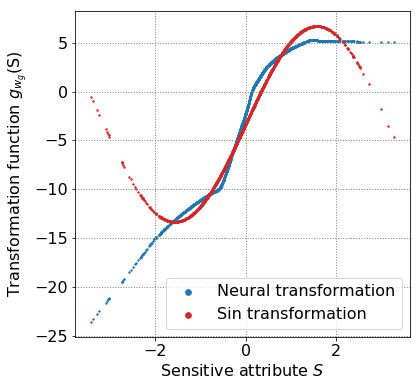

In [28]:
from sklearn.linear_model import LinearRegression


lreg = LinearRegression()
lreg.fit(np.sin(s_var.data.numpy()),mG(s_var).data.numpy())
sin_transf = lreg.predict(np.sin(s_var.data.numpy()))

fig, ax1 = plt.subplots()
ax1.set_facecolor('white')
ax1.grid(color='gray', linestyle=':', linewidth=1)
color = 'tab:blue'
ax1.set_xlabel('Sensitive attribute $S$')
ax1.set_ylabel('Transformation function $g_{w_{g}}}$(S)')

ax1.scatter(s_var.data.numpy(),mG(s_var).data.numpy(), color='tab:blue',s=2, label = 'Neural transformation')
ax1.scatter(s_var.data.numpy(), sin_transf, color = 'tab:red', s= 2, label = 'Sin transformation')

leg = ax1.legend(loc = 'lower right', markerscale = 4)
plt.savefig("sin_lam" + str(lambda_)+'.pdf',bbox_inches='tight')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.


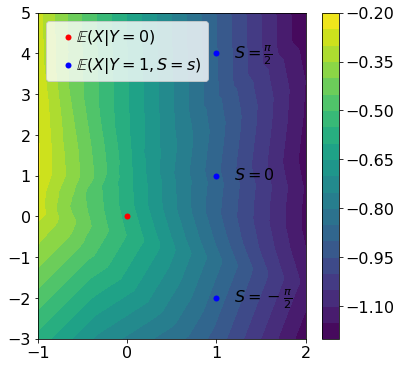

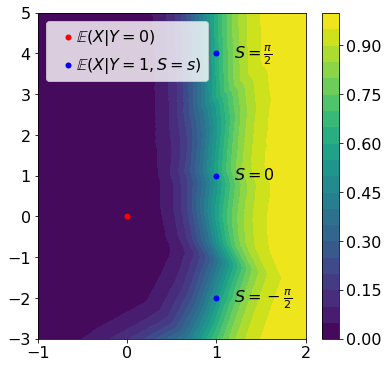

In [29]:
from matplotlib.mlab import griddata
from sklearn.decomposition import PCA


X_cp = 10*np.random.rand(30000,2) - 5
Z = m_encodeder(torch.FloatTensor(X_cp)).data.numpy()
y_pred = model(m_encodeder(torch.FloatTensor(X_cp))).data.numpy().reshape((-1,))


plt.figure(0)
xi = np.linspace(-1, 2, 300)
yi = np.linspace(-3, 5, 300)
zi = griddata(X_cp[:, 0], X_cp[:, 1], Z[:,0], xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mathbb{E}(X|Y=0)$")
plt.scatter([1], [-2], c="blue", linewidths=0, label=r"$\mathbb{E}(X|Y=1,S=s)$")
plt.scatter([1], [1], c="blue", linewidths=0)
plt.scatter([1], [4], c="blue", linewidths=0)
plt.text(1.2, -2-0.1, r'$S=-\frac{\pi}{2}$', color="k")
plt.text(1.2, 1-0.1, "$S=0$", color="k")
plt.text(1.2, 4-0.1, r'$S=\frac{\pi}{2}$', color="k")
plt.xlim(-1,2)
plt.ylim(-3,5)
plt.legend(loc="upper left", scatterpoints=1, handletextpad = -0.5)
plt.savefig("contourZ_lam" + str(lambda_)+'.pdf')

plt.figure(1)
xi = np.linspace(-1, 2, 300)
yi = np.linspace(-3, 5, 300)
zi = griddata(X_cp[:, 0], X_cp[:, 1], y_pred, xi, yi, interp="linear")
CS = plt.contourf(xi, yi, zi, 20, cmap=plt.cm.viridis, vmin = 0, vmax = 1)
plt.colorbar() 
plt.scatter([0], [0], c="red", linewidths=0, label=r"$\mathbb{E}(X|Y=0)$")
plt.scatter([1], [-2], c="blue", linewidths=0, label=r"$\mathbb{E}(X|Y=1,S=s)$")
plt.scatter([1], [1], c="blue", linewidths=0)
plt.scatter([1], [4], c="blue", linewidths=0)
plt.text(1.2, -2-0.1, r'$S=-\frac{\pi}{2}$', color="k")
plt.text(1.2, 1-0.1, "$S=0$", color="k")
plt.text(1.2, 4-0.1, r'$S=\frac{\pi}{2}$', color="k")
plt.xlim(-1,2)
plt.ylim(-3,5)
plt.legend(loc="upper left", scatterpoints=1, handletextpad = -0.5)
plt.savefig("contourY_lam" + str(lambda_) + '.pdf')

plt.show()


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


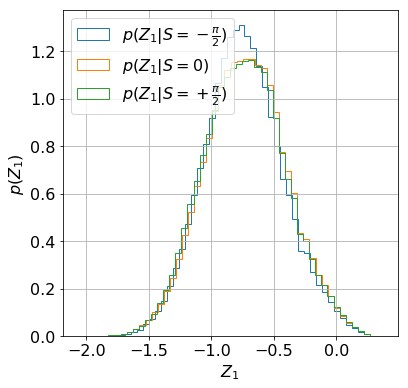

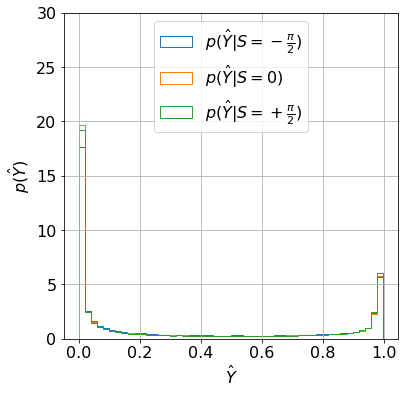

In [30]:
def make_X(n_samples, s):
    X0 = p0.rvs(n_samples // 2, random_state = 42)
    X1 = p1.rvs(n_samples // 2, random_state = 42)
    X1[:, 1] += 3*np.sin(s)
    X = np.vstack([X0, X1])
    return X

Z_ = m_encodeder(torch.FloatTensor(make_X(200000, s=-np.pi/2))).data.numpy()
y_ = model(m_encodeder(torch.FloatTensor(make_X(200000, s=-np.pi/2)))).data.numpy()

Z0 = m_encodeder(torch.FloatTensor(make_X(200000, s=0))).data.numpy()
y0 = model(m_encodeder(torch.FloatTensor(make_X(200000, s=0)))).data.numpy()

Z1 = m_encodeder(torch.FloatTensor(make_X(200000, s=+np.pi/2))).data.numpy()
y1 = model(m_encodeder(torch.FloatTensor(make_X(200000, s=+np.pi/2)))).data.numpy()

plt.figure(0)
plt.hist(Z_[:,0], bins=50, normed=1, histtype="step", label=r"$p(Z_1|S=-\frac{\pi}{2})$")
plt.hist(Z0[:,0], bins=50, normed=1, histtype="step", label="$p(Z_1|S=0)$")
plt.hist(Z1[:,0], bins=50, normed=1, histtype="step", label=r"$p(Z_1|S=+\frac{\pi}{2})$")
#plt.ylim(0,1.3)
#plt.xlim(-15,3)
plt.xlabel("$Z_1$")
plt.ylabel("$p(Z_1)$")
plt.grid()
plt.legend(loc="upper left")
plt.savefig("distribZ_lam" + str(lambda_)+'.pdf')


plt.figure(1)
plt.hist(y_, bins=50, normed=1, histtype="step", label=r"$p(\hat{Y}|S=-\frac{\pi}{2})$")
plt.hist(y0, bins=50, normed=1, histtype="step", label="$p(\hat{Y}|S=0)$")
plt.hist(y1, bins=50, normed=1, histtype="step", label=r"$p(\hat{Y}|S=+\frac{\pi}{2})$")
plt.legend(loc="upper center")
plt.ylim(0,30)
plt.xlabel("$\hat{Y}$")
plt.ylabel("$p(\hat{Y})$")
plt.grid()
plt.savefig("distribY_lam" + str(lambda_) + '.pdf')

plt.show()

# **HGR($\hat{Y}$,S)**

In [31]:


import torch
import torch.nn as nn
import torch.nn.functional as F
H = 8
H2 = 8


class Net_HGR_y(nn.Module):
    def __init__(self):
        super(Net_HGR_y, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4    


class Net2_HGR_y(nn.Module):
    def __init__(self):
        super(Net2_HGR_y, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, H2)
        self.fc4 = nn.Linear(H2, 1)
        self.bn1 = nn.BatchNorm1d(1)

    def forward(self, x):
        h1 = torch.tanh(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        h4 = self.fc4(h3)
        return h4    


class HGR_NN_y(nn.Module):
    
    def __init__(self,model_F,model_G):
        super(HGR_NN_y, self).__init__()
        self.mF = model_F
        self.mG = model_G
        self.optimizer_F = torch.optim.Adam(self.mF.parameters(), lr=0.0005)
        self.optimizer_G = torch.optim.Adam(self.mG.parameters(), lr=0.0005)

    def forward(self, yhat, y2_var,nb):
        yhat0 = yhat.detach()
        y2_var0 = y2_var.detach()
        for j in range(nb) :
            #ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
            #ret = torch.mean(pred_xy) - torch.mean(pred_x_y) - 0.25*torch.mean(torch.pow(pred_x_y,2))

            #yhat2  =yhat.data.numpy()
            #y2_var2=y2_var.data.numpy()
        
            #yhat2_PT  = torch.from_numpy(yhat2).type(torch.FloatTensor)
            #y2_var_PT = torch.from_numpy(y2_var2).type(torch.FloatTensor)

            pred_F  = self.mF(yhat0)
            pred_G  = self.mG(y2_var0)

            epsilon=0.0000000000000000001
            #epsilon=0.0001 
            pred_F_norm = (pred_F-torch.mean(pred_F))/torch.sqrt((torch.std(pred_F).pow(2)+epsilon))
            pred_G_norm = (pred_G-torch.mean(pred_G))/torch.sqrt((torch.std(pred_G).pow(2)+epsilon))
            #pred_F_norm[torch.isnan(pred_F_norm )] = 0
            #pred_G_norm[torch.isnan(pred_G_norm )] = 0

            ret = torch.mean(pred_F_norm*pred_G_norm)
            loss = - ret  # maximize
            self.mF.zero_grad()
            self.mG.zero_grad()
            loss.backward()
            if (j%500) ==0 : 
              print('Iteration j :', j, 'HGR :', ret)
            self.optimizer_F.step()
            self.optimizer_G.step()

        return ret.data.numpy()


In [32]:
torch.manual_seed(1)
model_Net_F = Net_HGR_y()

torch.manual_seed(1)
model_Net_G = Net2_HGR_y()

HGR_NNP = HGR_NN_y(model_Net_F,model_Net_G)

hgr_test_y = HGR_NNP(model(m_encodeder(torch.FloatTensor(X_test))),torch.FloatTensor(sensitivet).unsqueeze(1),2000)
print('Testing HGR(Y^,S) :', hgr_test_y)

Iteration j : 0 HGR : tensor(0.0096, grad_fn=<MeanBackward0>)
Iteration j : 500 HGR : tensor(0.0372, grad_fn=<MeanBackward0>)
Iteration j : 1000 HGR : tensor(0.0387, grad_fn=<MeanBackward0>)
Iteration j : 1500 HGR : tensor(0.0389, grad_fn=<MeanBackward0>)
Testing HGR(Y^,S) : 0.038921166


In [33]:
torch.manual_seed(1)
model_Net_F = Net_HGR_y()

torch.manual_seed(1)
model_Net_G = Net2_HGR_y()

HGR_NNP = HGR_NN_y(model_Net_F,model_Net_G)

hgr_train_y = HGR_NNP(model(m_encodeder(torch.FloatTensor(X_train))),torch.FloatTensor(sensitive).unsqueeze(1),2000)
print('Training HGR(Y^,S) :', hgr_train_y )

Iteration j : 0 HGR : tensor(0.0072, grad_fn=<MeanBackward0>)
Iteration j : 500 HGR : tensor(0.0331, grad_fn=<MeanBackward0>)
Iteration j : 1000 HGR : tensor(0.0337, grad_fn=<MeanBackward0>)
Iteration j : 1500 HGR : tensor(0.0347, grad_fn=<MeanBackward0>)
Training HGR(Y^,S) : 0.03480281
